In [2]:
import numpy as np
import pandas as pd
import os, sys

import json

import plotly.graph_objects as go
from plotly.subplots import make_subplots

/tmp/ipykernel_652/4213037997.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
data_dir = "/mnt/c/Users/Public/Documents/Uni/master/masterarbeit/ampel/ampel-results/random/TransientTable"
save_dir = "./pics/random/"
os.makedirs(save_dir, exist_ok=True)
data_files = [file for file in os.listdir(data_dir) if ".csv" in file and "~lock" not in file]

total_dataframe = pd.DataFrame()
for datafile in data_files:
    tmp_df = pd.read_csv(os.path.join(data_dir, datafile), sep=";")
    total_dataframe = pd.concat((total_dataframe, tmp_df))


total_entries = len(total_dataframe)

In [4]:
print(total_entries)

16093


In [5]:
def jsonify(string: str):
    if type(string) != str:
        return ""
    tmp_str = string.replace("'", '"')
    tmp_str = tmp_str.replace("None", "null")
    tmp_str = tmp_str.replace("True", "true")
    tmp_str = tmp_str.replace("False", "false")
    tmp_str = tmp_str.replace("inf", 'Infinity')


    return tmp_str

## CHISQUARE STUFF

In [6]:


#print(total_dataframe.head())


pos_rowslist_dict = {"bns_maurice_1": [], "bns_maurice_2": [], "bns_maurice_3": [], "bns_maurice_4": []}
total_dataframe["ndet"] = np.zeros(len(total_dataframe))
rowslist = []
ndet_list = []
for k, row in total_dataframe.iterrows():
    dec_str = jsonify(row["rise_decline"])
    #print(tmp_str)
    dec_dict = json.loads(dec_str)
    #print(dec_dict["ndet"], row["kilonovaness"])

    ndet_list.append(dec_dict["ndet"])

    rowslist.append(dec_dict)

    #print(row["chisquares"])
    pos_str = jsonify(row["chisquares"])
    #print(row["chisquares"])
    #print(pos_str)
    if pos_str != "":
        pos_dict = json.loads(pos_str)
        #print(pos_dict)
        for key, value in pos_dict.items():
            value["ndet"] = dec_dict["ndet"]
            value["latest_det"] = dec_dict["jd_last"]
            value["first_det"] = dec_dict["jd_det"]
            value["kilonovaness"] = row["kilonovaness"]
            value["map_seed"] = row["map_seed"]
            value["map_dist"] = row["map_dist"]
            value["map_area"] = row["map_area"]
            if value["ndof"] > 0:
                value["red_chisqu"] = value["chisq"] / value["ndof"]
            else:
                value["red_chisqu"] = -999
            pos_rowslist_dict[key].append(value)
    #print(row["rise_decline"]["ndet"])

total_dataframe["ndet"] = ndet_list

print(rowslist[0])
print(len(rowslist))
pos_df_dict = {}
for key in pos_rowslist_dict:
    pos_df_dict[key] = pd.DataFrame(pos_rowslist_dict[key]).sort_values(by="ndet")

print(len(pos_df_dict[key]))

{'ndet': 1, 'frac_pos': 1.0, 'jd_det': 2458782.6137037, 'jd_last': 2458782.6137037, 't_lc': 0.0, 't_predetect': 0.0009027998894453049, 'mag_det': 19.92975425720215, 'band_det_id': 128, 'mag_last': 19.92975425720215, 'band_last_id': 128, 'mag_min': 19.92975425720215, 'jd_min': 2458782.6137037, 'bool_pure': True, 'jd_peak_ztfr': 2458782.6137037, 'rise_slope_ztfr': 15224.131117851935, 'rise_slopesig_ztfr': 0.4350125425507666, 'bool_rise': False, 'bool_fall': False, 'bool_peaked': False, 'bool_fastrise': None, 'bool_fastfall': None, 'bool_hasgaps': False, 'det_bands': 128, 'last_bands': 128, 'success': True}
16093
7601


In [7]:
total_dataframe[["kilonovaness", "ndet", "rise_decline"]]

kilonovaness  ndet                                       rise_decline
0              6     1  {'ndet': 1, 'frac_pos': 1.0, 'jd_det': 2458782...
1              4     4  {'ndet': 4, 'frac_pos': 1.0, 'jd_det': 2458782...
2              1     1  {'ndet': 1, 'frac_pos': 1.0, 'jd_det': 2458781...
3              1     1  {'ndet': 1, 'frac_pos': 1.0, 'jd_det': 2458781...
0             12     4  {'ndet': 4, 'frac_pos': 1.0, 'jd_det': 2459071...
..           ...   ...                                                ...
40             1     1  {'ndet': 1, 'frac_pos': 1.0, 'jd_det': 2459099...
41             1     2  {'ndet': 2, 'frac_pos': 1.0, 'jd_det': 2459099...
42             1     2  {'ndet': 2, 'frac_pos': 1.0, 'jd_det': 2459099...
0              3     2  {'ndet': 2, 'frac_pos': 1.0, 'jd_det': 2459027...
0              6     1  {'ndet': 1, 'frac_pos': 1.0, 'jd_det': 2460016...

[16093 rows x 3 columns]

In [8]:
keys = list(pos_df_dict.keys())
key = keys[0]

fig = go.Figure()

max_red_chisq = 100
n_bins = 10
bins = np.linspace(0.8, max_red_chisq, n_bins)
print("bins:", bins)

os.makedirs(save_dir, exist_ok=True)
for key in keys[:]:

    total_number = len(pos_df_dict[key])
    print(f"% entries with fit:", key, ": ", total_number / total_entries)
    above_0_ndof = len(pos_df_dict[key][pos_df_dict[key]["ndof"] > 0])
    percentage_above_0_ndof = above_0_ndof / total_entries * 100
    print("ndof > 0:", above_0_ndof,"is",  percentage_above_0_ndof, "%")

    tmp_data = pos_df_dict[key].copy()[np.logical_and(pos_df_dict[key]["chisq"] <= max_red_chisq, pos_df_dict[key]["chisq"] >= 0.8) ]

    tmp_hist = np.histogram(tmp_data["red_chisqu"], bins=bins)
    #print(tmp_hist)

    fig.add_trace(go.Bar(x=bins, y = tmp_hist[0]/total_entries*100, name=key))
    #fig.add_trace(go.Histogram(x=tmp_data["chisq"], name=key))
fig.update_layout({"xaxis_title": "reduced chisqu",
                   "yaxis_title": "Portion of all candidates (%)",
                   "title": "Reduced chisqu. distribution over random maps",
                   "width": 600})
fig.show()

filename = os.path.join(save_dir, "chisqu_dist.pdf")
fig.write_image(filename)

bins: [  0.8         11.82222222  22.84444444  33.86666667  44.88888889
  55.91111111  66.93333333  77.95555556  88.97777778 100.        ]
% entries with fit: bns_maurice_1 :  0.47231715652768286
ndof > 0: 3351 is 20.822717951904554 %
% entries with fit: bns_maurice_2 :  0.47231715652768286
ndof > 0: 3351 is 20.822717951904554 %
% entries with fit: bns_maurice_3 :  0.47231715652768286
ndof > 0: 3351 is 20.822717951904554 %
% entries with fit: bns_maurice_4 :  0.47231715652768286
ndof > 0: 3351 is 20.822717951904554 %


## NDET STUFF

In [9]:
ndet_hist = np.histogram(total_dataframe["ndet"], bins=np.max(total_dataframe["ndet"]))

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.arange(np.max(total_dataframe["ndet"])), y=ndet_hist[0]/total_entries))
fig.update_layout({"xaxis_title": "Number of detections",
                   "yaxis_title": "Counts (relative)",
                   "xaxis_range": (0, 25),
                   "width": 500,
                   "title": "Number of detections in random map events"})
fig.show()
filename = os.path.join(save_dir, "ndet.pdf")
fig.write_image(filename)

In [10]:
import plotly.express as px

In [11]:


fig = px.density_heatmap(x=total_dataframe["ndet"], y=total_dataframe["kilonovaness"], text_auto=True)
fig.update_traces(
    marker=dict(size=2,
                              line=dict(width=2,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'),
                  
                  )
fig.update_layout({"xaxis_title": "ndet",
                   "yaxis_title": "kilonovaness"})

fig.show()
print(len(total_dataframe["ndet"]))

16093


### MEAN NDET IN RANDOM MAPS

In [12]:
maps = total_dataframe["map_seed"].unique()

max_ndet_list = []
mean_ndet_list = []
std_ndet_list = []
median_ndet_list = []
mean_kilonovaness_list = []
std_kilonovaness_list = []
max_kilonovaness_list = []
median_kilonovaness_list = []


for k, map in enumerate(maps):
    tmp_df = total_dataframe.copy()[total_dataframe["map_seed"] == map]

    mean_ndet_list.append(np.mean(tmp_df["ndet"]))
    max_ndet_list.append(np.max(tmp_df["ndet"]))
    median_ndet_list.append(np.median(tmp_df["ndet"]))
    std_ndet_list.append(np.std(tmp_df["ndet"]))

    mean_kilonovaness_list.append(np.mean(tmp_df["kilonovaness"]))
    std_kilonovaness_list.append(np.std(tmp_df["kilonovaness"]))
    max_kilonovaness_list.append(np.max(tmp_df["kilonovaness"]))
    median_kilonovaness_list.append(np.median(tmp_df["kilonovaness"]))

ndet_df = pd.DataFrame(
    {
        "map": maps,
        "max_ndet": max_ndet_list,
        "mean_ndet": mean_ndet_list,
        "std_ndet": std_ndet_list,
        "median_ndet": median_ndet_list,
        "mean_kilonovaness": mean_kilonovaness_list,
        "max_kilonovaness": max_kilonovaness_list,
        "median_kilonovaness": median_kilonovaness_list,
        "std_kilonovaness": std_kilonovaness_list
    }
)

ndet_df.sort_values(by="mean_ndet", ascending=False)

map  max_ndet  mean_ndet   std_ndet  median_ndet  \
489  1997784644        29  23.500000   4.716991         24.5   
486  1995400186        23  23.000000   0.000000         23.0   
357  1730629248        84  22.333333  29.864509          7.0   
62   1130200261        21  21.000000   0.000000         21.0   
225  1460811730        29  19.200000   9.641577         25.0   
..          ...       ...        ...        ...          ...   
737    50929686         1   1.000000   0.000000          1.0   
755   545461069         1   1.000000   0.000000          1.0   
756   546348052         1   1.000000   0.000000          1.0   
6    1012400298         1   1.000000   0.000000          1.0   
967   998442192         1   1.000000   0.000000          1.0   

     mean_kilonovaness  max_kilonovaness  median_kilonovaness  \
489           5.166667                12                  2.0   
486          12.000000                12                 12.0   
357           9.833333                13                 11.0   
62           14.000000                14                 14.0   
225           6.200000                 7                  6.0   
..                 ...               ...                  ...   
737           3.000000                 3                  3.0   
755           9.750000                10                 10.0   
756           3.000000                 3                  3.0   
6             1.000000                 1                  1.0   
967           6.000000                 6                  6.0   

     std_kilonovaness  
489          4.487637  
486          0.000000  
357          3.287180  
62           0.000000  
225          0.400000  
..                ...  
737          0.000000  
755          0.433013  
756          0.000000  
6            0.000000  
967          0.000000  

[968 rows x 9 columns]

In [13]:
from ampel.contrib.hu.t3 import RandomMapGenerator
from ampel.log import AmpelLogger

In [14]:
rmg = RandomMapGenerator.RandomMapGenerator(logger=AmpelLogger())

map_ras = []
map_decs = []
map_times = []
map_dists = []

for seed in ndet_df["map"]:

    rmg.seed = seed
    rmg.generate_randoms()

    map_ras.append(rmg.longitude)
    map_decs.append(rmg.latitude)
    map_times.append(rmg.trigger_time)
    map_dists.append(rmg.distance)

ndet_df["map_ra"] = map_ras
ndet_df["map_dec"] = map_decs
ndet_df["map_time"] = map_times
ndet_df["map_dist"] = map_dists

In [15]:
import matplotlib.pyplot as plt
import matplotlib as mplt

In [16]:
def plot_mwd(RA,Dec,org=0,title='Mollweide projection', projection='mollweide', c=None, cmap=plt.get_cmap("magma"), norm=mplt.colors.Normalize()):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    '''
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection=projection)
    sc = ax.scatter(np.radians(x),np.radians(Dec), c=c, cmap=cmap, marker="o", edgecolors="black", linewidths=1,
                    norm=norm)  # convert degrees to radians
    #fig.colorbar(sc)
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    return fig, ax, sc

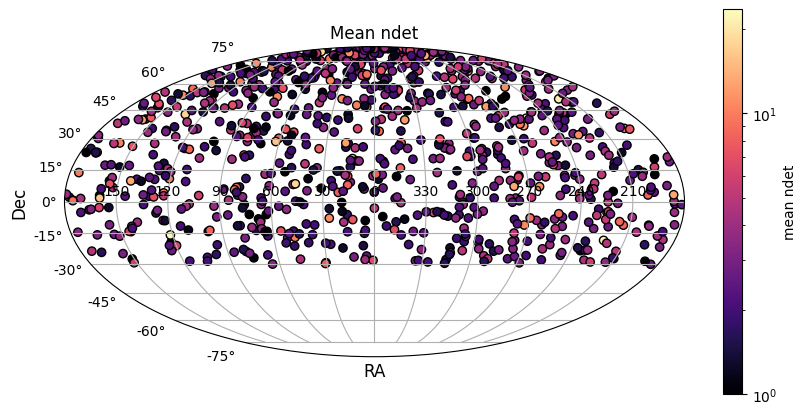

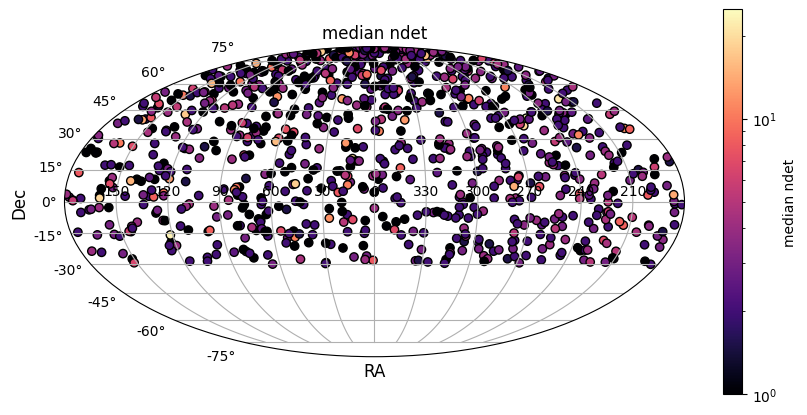

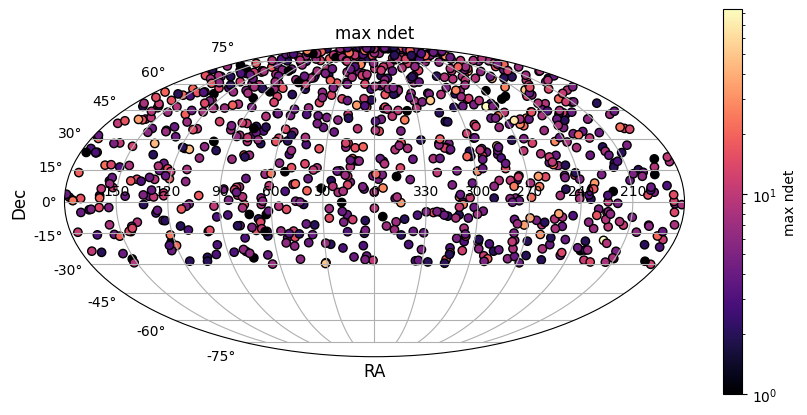

In [17]:

fig, ax, sc = plot_mwd(ndet_df["map_ra"], ndet_df["map_dec"], c=ndet_df["mean_ndet"], cmap=plt.get_cmap("magma"), norm=mplt.colors.LogNorm())
ax.set_title("Mean ndet")
fig.colorbar(sc).set_label("mean ndet")

fig, ax, sc = plot_mwd(ndet_df["map_ra"], ndet_df["map_dec"], c=ndet_df["median_ndet"], cmap=plt.get_cmap("magma"), norm=mplt.colors.LogNorm())
ax.set_title("median ndet")
fig.colorbar(sc).set_label("median ndet")

fig, ax, sc = plot_mwd(ndet_df["map_ra"], ndet_df["map_dec"], c=ndet_df["max_ndet"], cmap=plt.get_cmap("magma"), norm=mplt.colors.LogNorm())
ax.set_title("max ndet")
fig.colorbar(sc).set_label("max ndet")

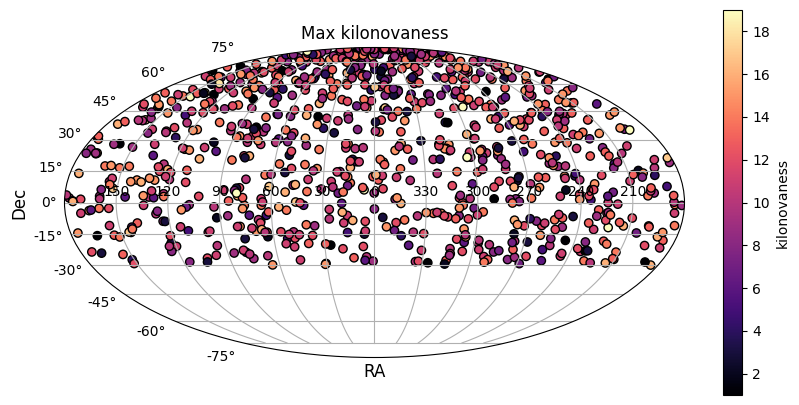

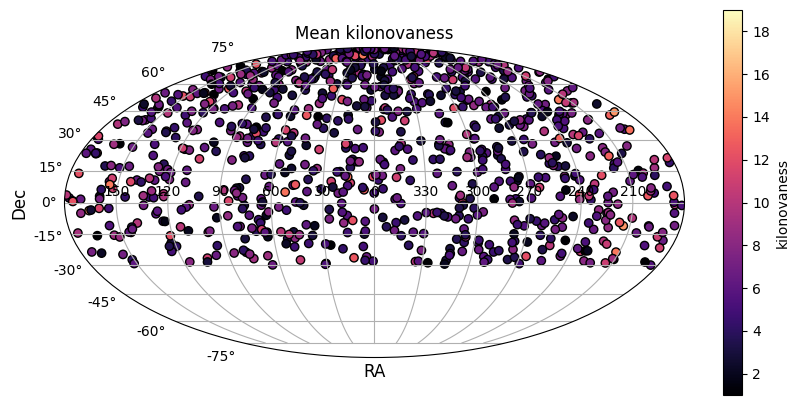

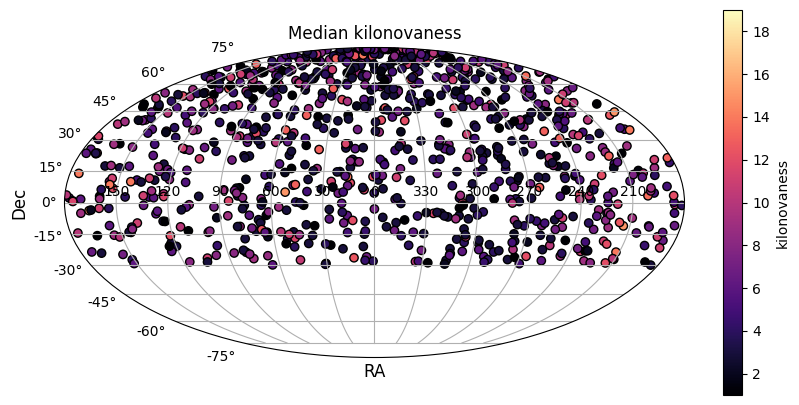

In [18]:
fig, ax, sc = plot_mwd(ndet_df["map_ra"], ndet_df["map_dec"], c=ndet_df["max_kilonovaness"])
ax.set_title("Max kilonovaness")
fig.colorbar(sc).set_label("kilonovaness")

fig, ax, sc = plot_mwd(ndet_df["map_ra"], ndet_df["map_dec"], c=ndet_df["mean_kilonovaness"])
ax.set_title("Mean kilonovaness")
fig.colorbar(sc).set_label("kilonovaness")

fig, ax, sc = plot_mwd(ndet_df["map_ra"], ndet_df["map_dec"], c=ndet_df["median_kilonovaness"])
ax.set_title("Median kilonovaness")
fig.colorbar(sc).set_label("kilonovaness")

In [19]:
fig = go.Figure()

fig.add_trace(go.Histogram(x=ndet_df["mean_kilonovaness"],histnorm='probability'))
fig.update_layout(width=700, xaxis_title="Kilonovaness")
fig.show()
print(len(ndet_df))

968


In [20]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=ndet_df["mean_kilonovaness"], x=ndet_df["mean_ndet"], mode="markers", name="mean kilonovaness"))
fig.add_trace(go.Scatter(y=ndet_df["max_kilonovaness"], x=ndet_df["mean_ndet"], mode="markers", name="max kilonovaness", opacity=0.4))

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=ndet_df["mean_kilonovaness"], x=ndet_df["median_ndet"], mode="markers", name="mean kilonovaness"))
fig.add_trace(go.Scatter(y=ndet_df["max_kilonovaness"], x=ndet_df["median_ndet"], mode="markers", name="max kilonovaness", opacity=0.4))

## BINNED ndet and dist

In [22]:
ndet_bins_mins = [0, 4, 10, 0]
ndet_bins_maxs = [4, 10, np.inf, np.inf]
dist_bins_mins = [0, 400, 800, 1200, 1600, 0]
dist_bins_maxs = [400, 800, 1200, 1600, np.inf, np.inf]

pattern_shape_sequence=[".", "x", "/", "\\"]
colors = ["red", "green", "blue", "orange", "grey", "purple"]

In [23]:
fig = make_subplots(cols=len(ndet_bins_maxs), rows=len(dist_bins_maxs), vertical_spacing=0.1, horizontal_spacing=0.1)

for col, ndet_max in enumerate(ndet_bins_maxs[:]):
    pattern = pattern_shape_sequence[col]
    ndet_min = ndet_bins_mins[col]
    ndet_mask = np.logical_and(ndet_min <= ndet_df["mean_ndet"], ndet_df["mean_ndet"] <= ndet_max)

    for row, dist_max in enumerate(dist_bins_maxs[:]):
        color = colors[row]

        dist_min = dist_bins_mins[row]     
        dist_mask = np.logical_and(dist_min <= ndet_df["map_dist"], ndet_df["map_dist"] <= dist_max)

        binned_df = ndet_df[np.logical_and(ndet_mask, dist_mask)].copy()
        #fig.add_trace(go.Scatter(y=binned_df["mean_kilonovaness"], x=binned_df["median_ndet"], mode="markers"),
        #              row=row+1, col=col+1)
        
        fig.add_trace(go.Histogram(x=binned_df["mean_kilonovaness"], marker_pattern={"bgcolor": color, "shape":pattern}, histnorm='probability', xbins={"start": 0, "end": 20, "size": 1}), 
                      row=row+1, col=col+1)

        subplot_title = f"[{dist_min}, {dist_max}] Mpc; [{ndet_min}, {ndet_max}] ndet, <br> counts={len(binned_df)}"
        fig.add_annotation(
        xref="x domain",
        yref="y domain",
        showarrow=False,
        # The arrow head will be 25% along the x axis, starting from the left
        x=0,
        # The arrow head will be 40% along the y axis, starting from the bottom
        y=1.5,
        text=subplot_title,
        # arrowhead=2,

        row=row+1,

        col=col+1
    )

fig.update_layout(height=1300, width=1000,
                  title_text="Mean Kilonovaness, binned in GW map distance and ndet",
                  showlegend=False,
                  xaxis_title="kilonovaness",
                  )
fig.write_image("./pics/random/mean_kilonovaness_binned.pdf")
fig.show()

In [24]:
ndet_df.sort_values(by="mean_kilonovaness", ascending=False).head()

map  max_ndet  mean_ndet  std_ndet  median_ndet  \
683   422550513         4        4.0       0.0          4.0   
569   236839909         2        2.0       0.0          2.0   
451  1938129510        11        8.5       2.5          8.5   
500  2031514457         5        5.0       0.0          5.0   
809   654422482         3        3.0       0.0          3.0   

     mean_kilonovaness  max_kilonovaness  median_kilonovaness  \
683               15.0                15                 15.0   
569               15.0                15                 15.0   
451               15.0                16                 15.0   
500               14.0                14                 14.0   
809               14.0                14                 14.0   

     std_kilonovaness      map_ra    map_dec      map_time     map_dist  
683               0.0  188.421939  44.334866  1.362253e+09   739.448331  
569               0.0  165.935784  -3.816380  1.369586e+09   860.288440  
451               1.0  213.833996 -11.076898  1.290618e+09   297.775489  
500               0.0  211.999446 -23.608216  1.372577e+09  1200.506023  
809               0.0   21.564530  80.788963  1.350508e+09   652.287425

In [25]:
from scipy.optimize import minimize
from scipy.special import factorial
from scipy import stats

In [26]:
def gaus(params, data):
    loc = params[0]
    scale = params[1]
    return stats.norm.pdf(data, loc=loc, scale=scale)

def gaus_curve(data, loc, scale):
    return stats.norm.pdf(data, loc=loc, scale=scale)

def neg_log_like(params, data):
    loc = params[0]
    scale = params[1]
    return -stats.norm.logpdf(data, loc=loc, scale=scale).sum()

In [27]:
def gamma(params, data):
    loc = params[0]
    scale = params[1]
    a = params[2]
    return stats.gamma.pdf(data, a, loc=loc)

def gamma_log(params, data):
    loc = params[0]
    scale = params[1]
    a = params[2]
    return -stats.gamma.logpdf(data, a, scale=scale).sum()

In [28]:
hist, bins = np.histogram(ndet_df["mean_kilonovaness"], bins=15)
hist_std, bins_std = np.histogram(ndet_df["std_kilonovaness"], bins=bins)

hist_rel = hist/sum(hist)

data = ndet_df["mean_kilonovaness"]
result = minimize(neg_log_like,
                  x0=np.ones(2),
                  args=(data, ),
                  method="Nelder-Mead")

result_gamma = minimize(gamma_log,
                         x0=(0, 1, 7.5),
                         args=(data, ),
                         method="Nelder-Mead")

kn_range = np.arange(22, step=0.1)
kn_fit = gaus(result.x, kn_range)
#kn_fit_gamma = gamma((0, 0, 7.5), kn_range)
kn_fit_gamma = gamma(result_gamma.x, kn_range)

print(result_gamma)

       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2329.170460253328
             x: [-1.298e-03  1.404e+00  4.304e+00]
           nit: 62
          nfev: 112
 final_simplex: (array([[-1.298e-03,  1.404e+00,  4.304e+00],
                       [-1.299e-03,  1.404e+00,  4.304e+00],
                       [-1.299e-03,  1.404e+00,  4.304e+00],
                       [-1.298e-03,  1.404e+00,  4.304e+00]]), array([ 2.329e+03,  2.329e+03,  2.329e+03,  2.329e+03]))


In [29]:
from scipy.optimize import curve_fit

In [30]:
hist, bins = np.histogram(ndet_df["mean_kilonovaness"], bins=np.arange(20))
print(hist, bins)
hist_rel = hist/sum(hist)
#hist_std, bins_std = np.histogram(ndet_df["std_kilonovaness"], bins=bins)

print(len(hist_rel), len(bins))

popt, pcov, info, msg, ier = curve_fit(gaus_curve, bins[:-1], hist_rel, p0=(1, 1), full_output=True)

kn_fit_curve = gaus_curve(kn_range, *popt)

print(popt, pcov, info)

[  0  34  67 119 146 158 137  88  68  44  35  29  25  10   5   3   0   0
   0] [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
19 20
[4.98213315 2.51047289] [[ 0.01797792 -0.0002643 ]
 [-0.0002643   0.01222061]] {'fvec': array([ 2.21790173e-02,  1.00407910e-02,  9.26322811e-03, -6.57789341e-03,
       -3.62217052e-03, -4.31595683e-03,  4.84309438e-03,  2.41349246e-02,
        6.90659562e-03, -1.30255853e-03, -1.45979307e-02, -2.09760750e-02,
       -2.26329581e-02, -9.36181036e-03, -4.91452489e-03, -3.04378714e-03,
        1.04383551e-05,  1.67861975e-06,  2.30337169e-07]), 'nfev': 34, 'fjac': array([[-1.13920551e-01,  2.39427712e-01,  1.12801192e-01,
        -1.53230975e-01, -4.35952529e-01, -5.55619975e-01,
        -4.27668472e-01, -1.42359798e-01,  1.20089852e-01,
         2.41064226e-01,  2.25779515e-01,  1.49061438e-01,
         7.60857514e-02,  3.11602450e-02,  1.04350015e-02,
         2.88944641e-03,  6.66308851e-04,  1.28589034e-04,
         2.08414383e-05],
     

In [53]:
fig = go.Figure()


save_file = "./pics/mean_kilonovaness_unbinned_nofit.pdf"


fig.add_trace(go.Bar(y=hist_rel, x=bins, name="Data", marker_color="orange", marker_line={"color": "black", "width": 4}))
#fig.add_trace(go.Scatter(y=kn_fit, x=kn_range, name="gaus loglike"))
#fig.add_trace(go.Scatter(y=kn_fit_gamma, x=kn_range, name="gamma"))
#fig.add_trace(go.Scatter(y=kn_fit_curve, x=kn_range, name="Gauss fit (Least Squares)"))
#fig.add_trace(go.Bar(y=hist, x=bins, name="Data 2"))
fig.add_vline(x=16, name="AT2017gfo 3 days post-merger", annotation={"text": "AT2017gfo 3 days   <br>post-merger", "align": "left", "font_size":19}, annotation_position="left", line_color="blue", line_dash="dashdot", line_width=5)
fig.update_layout({"xaxis_title": "Mean kilonovaness",
                   "width": 700,
                   "title": f"Discretized mean kilonovaness in <br>{len(ndet_df) } randomly generated maps",
                   "legend_visible": True,
                   })
fig.update_layout(
    plot_bgcolor='white',
    font_size=17
)
fig.update_xaxes(
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='white',
    range=(0, 18),
    tickfont_size=25,
    title_font_size=20
)
fig.update_yaxes(
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='white',
    range=(0, 0.2),
    tickfont_size=19,

)
fig.show()
fig.write_image(save_file)

In [32]:
fig = go.Figure()

fig.add_trace(go.Scatter(y=binned_df["mean_kilonovaness"], x=binned_df["median_ndet"], mode="markers", name="mean kilonovaness"))
fig.add_trace(go.Scatter(y=binned_df["max_kilonovaness"], x=binned_df["median_ndet"], mode="markers", name="max kilonovaness", opacity=0.4))
fig.show()

fig = go.Figure()

fig.add_trace(go.Histogram(x=binned_df["mean_kilonovaness"], name="mean kilonovaness"))
fig.add_trace(go.Histogram(x=binned_df["max_kilonovaness"], name="max kilonovaness", opacity=0.4))
fig.update
fig.show()